# ECE 57000 Assignment 5 Exercise

Your Name:

For this assignment, you will implement and explore various density estimation methods.

## Exercise 1: Density estimation in 1D
In this exercise, you will write code to estimate 1D densities.
Specifically, you will write code to estimate a Gaussian density, a histogram density, and a kernel density.

### Task 1.1: Gaussian density
For this first one you will estimate a Gaussian density via MLE.
As discussed in class, this simplifies to estimating the mean and standard devaition of the data and using these empirical estimates for the Gaussian distribution.
The Gaussian PDF can be evaluated using the function [`scipy.stats.norm.pdf`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.norm.html).

In [4]:
import numpy as np
import scipy.stats
from sklearn.base import BaseEstimator
class GaussianDensity(BaseEstimator):
    def fit(self, X, y=None):
        ##### Your code here #####
        # You should estimate the mean and variance of the data  and save as self.mean_ and self.std_
        # (note that X will be shape (n,1) because there is only 1 feature).
        self.mean_ = np.mean(X)
        self.std_ = np.std(X)
        ##########################
        return self
    
    def predict_proba(self, X):
        ##### Your code here #####
        # This should return the PDF values for each sample in X (again of shape (n, 1))
        # This should use your self.mean_ and self.std_ variables saved from the fit method
        if self.std_ == 0:
          pdf_values = 1
        else:
          pdf_values = 1/self.std_/np.sqrt(2*np.pi)*np.exp(-0.5*(X.reshape(-1)-self.mean_)**2/self.std_**2)
        return pdf_values  # Output should be of shape (n,), i.e., a 1D array
        ##########################

### Task 1.2: Histogram density
Now you will implement a histogram density estimate given min, max and number of bins.
The function [`np.searchsorted`](https://numpy.org/doc/stable/reference/generated/numpy.searchsorted.html) may be useful but is not required.

NOTE: The value of the histogram outside of the min max values should be set to 0.

In [5]:
import numpy as np
import scipy.stats
from sklearn.base import BaseEstimator
class HistogramDensity(BaseEstimator):
    def __init__(self, n_bins, min_val, max_val):
        self.n_bins = n_bins
        self.min_val = min_val
        self.max_val = max_val
    
    def fit(self, X, y=None):
        ##### Your code here #####
        # First create equally spaced bin_edges based on min_val, max_val and n_bins
        #  and save as self.bin_edges_
        #  (note the shape of self.bin_edges_ should be (n_bins+1,) )
        # Second, estimate the frequency for each bin based on the input data X
        #  (i.e., the number of training samples that fall into that bin divided 
        #  by the total number of samples)
        # Third, using the probability for each bin, compute the density value (i.e., PDF) for
        #  each bin. (Note you will have to account for the width of the bin to ensure
        #  that integrating your density function from min_value to max_value will be 1).
        #  Save the density per bin as self.pdf_per_bin_ which should have the shape (n_bins,)
        self.norm = (self.max_val-self.min_val)/self.n_bins
        self.size = X.shape[0]
        self.bin_edges_ = [self.min_val+self.norm*i for i in range(self.n_bins+1)]
        self.freq_per_bin_ = [0]*self.n_bins
        for i in X.reshape(-1):
          bin_num = int((i-self.min_val)/self.norm)
          if bin_num < self.n_bins and bin_num >=0:
            self.freq_per_bin_[bin_num]+=1
          elif bin_num == self.n_bins:
            self.freq_per_bin_[self.n_bins-1]+=1

        self.pdf_per_bin_ = np.array(self.freq_per_bin_)/self.size/self.norm
        ##########################
        return self
    
    def predict_proba(self, X):
        ##### Your code here #####
        # You should return the PDF value of the samples X.  This requires finding out which
        #  bin each sample falls into and returning it's corresponding density value
        #  **Importantly, if the value is less than min_value or greater than max_value, 
        #    then a pdf value of 0 should be returned.
        pdf_values = []
        for i in X.reshape(-1):
          if i < self.max_val and i >= self.min_val:
            pdf_values.append(self.pdf_per_bin_[int((i-self.min_val)/self.norm)])
          elif i == self.max_val:
            pdf_values.append(self.pdf_per_bin_[self.n_bins-1])
          else:
            pdf_values.append(0)

        return np.array(pdf_values)  # Output should be of shape (n,), i.e., a 1D array
        ##########################

### Task 1.3: Kernel density
Now you will implement a kernel density estimate (KDE) via a Gaussian kernel given the bandwidth parameter (i.e., the standard deviation of the Gaussian kernel.
Specifically, the Gaussian kernel density is given by:
$$p(x; \mathcal{D}) = \frac{1}{n}\sum_{i=1}^n p_{\mathcal{N}}(x; \mu = x_i, \sigma=h) $$
where $\mathcal{D}=\{x_i\}_{i=1}^n$ is a training dataset of $n$ samples, $p_{\mathcal{N}}$ is the Gaussian/normal density function and $h$ is called the bandwidth hyperparameter of the KDE model.
(Note that fitting merely requires saving the training dataset and using it to compute densities of new samples.)

In [6]:
import numpy as np
import scipy.stats
from sklearn.base import BaseEstimator
class KernelDensity(BaseEstimator):
    def __init__(self, bandwidth):
        self.bandwidth = bandwidth
    
    def fit(self, X, y=None):
        ##### Your code here #####
        # Save the training data in self.X_train_
        self.X_train_ = X.reshape(-1)
        self.size = self.X_train_.shape[0]
        ##########################
        return self
    
    def predict_proba(self, X):
        ##### Your code here #####
        # You should return the KDE PDF value of the samples X.
        #  Note that the sum above is over the TRAINING samples, not the test samples
        #  so you should use the samples saved in the fit method.
        pdf_values = [1/self.size*np.sum(1/self.bandwidth/np.sqrt(2*np.pi)*np.exp(-0.5*(sample-self.X_train_)**2/self.bandwidth**2),axis=0) for sample in X.reshape(-1)]
        return np.array(pdf_values)  # Output should be of shape (n,), i.e., a 1D array
        ##########################

### Test code
The following code will test each of your density estimators.
Run this to test your code and this is what will be used for grading your code.

(200, 1) (200, 1)
Fitting GaussianDensity model
True, Shape=(1000,) - Is the output the correct shape?
True, Num neg=0 - Are all pdf values >= 0? 
True, quad_out=0.999983773035064 - Does the PDF integrate to 1? 

Fitting HistogramDensity model
True, Shape=(1000,) - Is the output the correct shape?
True, Num neg=0 - Are all pdf values >= 0? 
True, quad_out=1.0000108157121521 - Does the PDF integrate to 1? 

Fitting KernelDensity model
True, Shape=(1000,) - Is the output the correct shape?
True, Num neg=0 - Are all pdf values >= 0? 
True, quad_out=0.9999999999999999 - Does the PDF integrate to 1? 



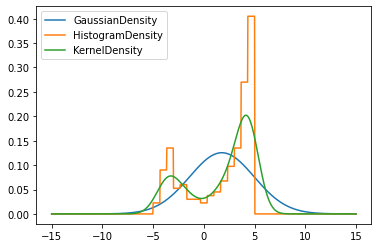

In [7]:
import scipy.stats
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
# Generate some data and split into train and test
min_val, max_val = -5, 5
diff = max_val - min_val
X = diff * np.vstack([scipy.stats.beta(6,1).rvs(size=(300,1)), scipy.stats.beta(2,7).rvs(size=(100,1))]) - diff/2
X_train, X_test = train_test_split(X, test_size=0.5, random_state=15)
print(X_train.shape, X_test.shape)

# Loop through models
models = [GaussianDensity(), 
          HistogramDensity(n_bins=15, min_val=min_val, max_val=max_val),
          KernelDensity(bandwidth=1)
         ]
for model in models:
    print(f'Fitting {type(model).__name__} model')
    # Fit models
    model.fit(X_train)

    # Sanity checks 
    xq = np.linspace(min_val-diff, max_val+diff, num=1000)
    pdf_vals = model.predict_proba(xq.reshape(-1, 1))
    # Check that right size and >= 0
    print(f'{len(pdf_vals.shape) == 1 and pdf_vals.shape[0] == len(xq)}, Shape={pdf_vals.shape}'
          f' - Is the output the correct shape?') 
    print(f'{np.all(pdf_vals>=0)}, Num neg={np.sum(pdf_vals < 0)} - Are all pdf values >= 0? ')
    
    # Check that integrates to 1 vai approximate numerical integration
    model_pdf = lambda x: model.predict_proba(np.array(x).reshape(1,1))[0]
    quad_out = scipy.integrate.quad(model_pdf, min_val - diff, max_val + diff, limit=100, full_output=True)
    print(f'{np.abs(quad_out[0] - 1) < 1e-4}, quad_out={quad_out[0]} - Does the PDF integrate to 1? ')
    print('')

    # Plot density model
    plt.plot(xq, pdf_vals, label=type(model).__name__)
    
plt.legend()

## Exercise 2: Determine optimal hyperparameters based on 10-fold cross validation
In this exercise, you need to write code that will use your estimators from above to automatically choose the best hyperparameters for the histogram and kernel density estimator.  In particular, find the best `n_bins` and `bandwidth` for the histogram and KDE respectively.

### Task 1: Implement custom scorer function for use in GridSearchCV
To do this, you will need to implement a `scorer` function that will compute the log likelihood of the data given (higher is better).
This function takes in the model, the input data X and y_true (which defaults to None since this is an unsupervised problem).

In [97]:
def mean_log_likelihood_scorer(model, X, y_true=None):
    ########## Your code here ########
    # Compute and return the mean log probability of the data
    #  (Note y_true is not used)
    mean_ll = np.mean(np.log(np.exp(1)+model.predict_proba(X)))
    return mean_ll
    ############

### Task 2: Estimate best hyperparameters
Then you can use sklearn's cross validation utilities to cross validate using the training data to determine the best parameters by passing this function as the `scoring` argument of GridSearchCV (note you just pass it directly as `mean_log_likelihood_scorer` without the parenthesis; this is known as passing a function to another function).

You should try 2-20 number of bins and a 50 bandwidth parameters linearly spaced between 0.1 and 10.

Finally, print out the optimal hyperparameters and, using the optimal hyperparameters, print out the log likelihood of the test data for both the histogram and KDE model.

In [116]:
############ Your code here #############
import scipy.stats
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

np.random.seed(0)

# Generate some data and split into train and test
min_val, max_val = -5, 5
diff = max_val - min_val
X = diff * np.vstack([scipy.stats.beta(6,1).rvs(size=(300,1)), scipy.stats.beta(2,7).rvs(size=(100,1))]) - diff/2
# print(np.amax(X),np.amin(X))

np.random.shuffle(X)

# candidate hyperparameters
parameters_hist = list(range(2,51,1))
parameters_KDE = np.linspace(0.001, 1, num=100)

best_score = -np.inf
best_param_bin = ''
for param_hist in parameters_hist:
  model = HistogramDensity(param_hist, min_val, max_val)
  scores  = np.array(cross_val_score(model, X, cv=10, scoring=mean_log_likelihood_scorer))
  score_avg = np.mean(scores)
  # print(score_avg)
  # print('best of Histogram Hyperparameters: \n\tbins:'+str(param_hist))
  if best_score < score_avg:
    best_score = score_avg
    best_param_bin = 'best of Histogram Hyperparameters: \n\tbins:'+str(param_hist)

print('optimal score of histogram model is '+str(best_score))
print(best_param_bin)

best_score2 = -np.inf
best_param_bin2 = ''
for param_KDE in parameters_KDE:
  model = KernelDensity(param_KDE)

  scores  = np.array(cross_val_score(model, X, cv=10, scoring=mean_log_likelihood_scorer))
  score_avg = np.mean(scores)
  # print(score_avg)
  # print('best of Histogram Hyperparameters: \n\tbins:'+str(param_KDE))
  if best_score2 < score_avg:
    best_score2 = score_avg
    best_param_bin2 = 'best of KDE Hyperparameters: \n\tthreshold:'+str(param_KDE)


print('optimal score of KDE model is '+str(best_score2))
print(best_param_bin2)

if best_score2 > best_score:
  print('Overall, optimal score of model is '+str(best_score2))
else:
  print('Overall, optimal score of model is '+str(best_score))
  # print(best_param_bin2)

optimal score of histogram model is 1.0739333408686451
best of Histogram Hyperparameters: 
	bins:37
optimal score of KDE model is 1.0769895937775769
best of KDE Hyperparameters: 
	threshold:0.001
Overall, optimal score of model is 1.0769895937775769
